In [10]:
%matplotlib inline
import numpy as np
import time
import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits import mplot3d
mpl.rcParams['lines.markersize'] = 3
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init
from torch.optim.lr_scheduler import ExponentialLR

import nn_models

torch.set_default_dtype(torch.float64)
torch.manual_seed(24)

MASS = 1.0
HBAR = 1.0
AUTOEV = 27.2114
AUTONM = 0.05291772108
NQGRID = 2048

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available.


In [2]:
def plotBandStruct(bandStruct_array, marker_array, label_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for bandStructIndex in range(len(bandStruct_array)): 
        numBands = len(bandStruct_array[bandStructIndex][0])
        numKpts = len(bandStruct_array[bandStructIndex])
        for i in range(numBands): 
            if i==0: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex], label=label_array[bandStructIndex])
            else: 
                axs.plot(np.arange(numKpts), bandStruct_array[bandStructIndex][:, i].detach().numpy(), marker_array[bandStructIndex])
    axs.legend(frameon=False)
    plt.show()
    return

def pot_func(x, params): 
    pot = (params[0]*(x*x - params[1]) / (params[2] * torch.exp(params[3]*x*x) - 1.0))
    return pot
    
def plotPP(q_array, vq_Cd_array, vq_Se_array, label_array, lineshape_array): 
    fig, axs = plt.subplots(1,1, figsize=(3,3))
    for i in range(len(q_array)): 
        q = q_array[i].detach().numpy()
        vq_Cd = vq_Cd_array[i].detach().numpy()
        vq_Se = vq_Se_array[i].detach().numpy()
        axs.plot(q, vq_Cd, lineshape_array[i], label="Cd "+label_array[i])
        axs.plot(q, vq_Se, lineshape_array[i], label="Se "+label_array[i])
    axs.set(xlabel=r"$q$", ylabel=r"$v(q)$")
    axs.legend(frameon=False)
    plt.show()
    return

def plot_training_validation_cost(training_cost, validation_cost): 
    if len(training_cost) != len(validation_cost): 
        return
    else:
        epochs = range(1, len(training_cost) + 1)
    
    # Plot training and validation costs
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, training_cost, "b-", label='Training Cost')
    plt.plot(epochs, validation_cost, "r:", label='Validation Cost')

    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()
    plt.title('Training and Validation Costs')
    plt.grid(True)
    plt.show()
    return

In [3]:
# Semiconductor system details
nSystem = 1

# read system
scale = 11.4485278
unitCellVector1 = torch.tensor([0.0, 0.5, 0.5]) * scale
unitCellVector2 = torch.tensor([0.5, 0.0, 0.5]) * scale
unitCellVector3 = torch.tensor([0.5, 0.5, 0.0]) * scale
unitCellVectors = torch.cat((unitCellVector1.unsqueeze(0), unitCellVector2.unsqueeze(0), unitCellVector3.unsqueeze(0)), dim=0)
cellVolume = torch.dot(unitCellVector1, torch.cross(unitCellVector2, unitCellVector3))

# calculate reciprocal space vectors
prefactor = 2 * np.pi / cellVolume
gVector1 = prefactor * torch.cross(unitCellVectors[1], unitCellVectors[2])
gVector2 = prefactor * torch.cross(unitCellVectors[2], unitCellVectors[0])
gVector3 = prefactor * torch.cross(unitCellVectors[0], unitCellVectors[1])
gVectors = torch.cat((gVector1.unsqueeze(0), gVector2.unsqueeze(0), gVector3.unsqueeze(0)), dim=0)

nAtoms = 2
atomTypes = np.array(["Cd", "Se"])
atomPos = torch.tensor([[0.125, 0.125, 0.125],
                        [-0.125, -0.125, -0.125]])
atomPos = atomPos @ unitCellVectors
# print(atomPos)

# read kPoints
kpt_zbCdSe = torch.tensor(np.loadtxt("ZB_kpoints.par"))
kpt_zbCdSe = kpt_zbCdSe @ gVectors
nkpt = kpt_zbCdSe.shape[0]
# Gamma = torch.tensor([0.0, 0.0, 0.0])

# read band strcture
Eref_zbCdSe = torch.tensor(np.loadtxt("bandStruct_zbCdSe.par")[:, 1:])

maxKE = 10

nBands = 16

In [4]:
# Current Cd, Se, S pp's in Zunger's form
CdParams = torch.tensor([-31.4518, 1.3890, -0.0502, 1.6603, 0.0586])
SeParams = torch.tensor([8.4921, 4.3513, 1.3600, 0.3227, 0.1746])
SParams = torch.tensor([7.6697, 4.5192, 1.3456, 0.3035, 0.2087])
PP_order = np.array(["Cd", "Se", "S"])
totalParams = torch.cat((CdParams.unsqueeze(0), SeParams.unsqueeze(0), SParams.unsqueeze(0)), dim=0)

class init_Zunger_data(Dataset):
    # Constructor
    def __init__(self,train=True):
        if train==True:
            self.q = torch.rand(4000, 1) * 10.0
            self.q[0:10, 0] = 0.0
            self.vq_Cd = pot_func(self.q, CdParams)
            self.vq_Se = pot_func(self.q, SeParams)
            mask = (self.q > 0) & (self.q < 1)
            self.w = torch.where(mask, torch.tensor(10.0), torch.tensor(1.0))
        elif train==False:
            self.q = torch.linspace(0.0, 10.0, NQGRID)
            self.vq_Cd = pot_func(self.q, CdParams)
            self.vq_Se = pot_func(self.q, SeParams)
            self.w = torch.ones_like(self.q)
        self.len = self.q.shape[0]
    # Getter
    def __getitem__(self,index):
        return self.q[index],self.vq_Cd[index],self.vq_Se[index],self.w[index]
    # Get Length
    def __len__(self):
        return self.len
    
train_dataset = init_Zunger_data(True)
print(train_dataset.w.shape)
print(train_dataset.vq_Cd.shape)

val_dataset = init_Zunger_data(False)
print(val_dataset.w.shape)

torch.Size([4000, 1])
torch.Size([4000, 1])
torch.Size([2048])


In [5]:
def basis(maxKE, scale, unitCellVectors, gVectors, cellVolume): 
    minGMag = min(torch.norm(gVectors[0]), torch.norm(gVectors[1]), torch.norm(gVectors[2]))
    numMaxBasisVectors = int(np.sqrt(2*maxKE) / minGMag)
    # print(numMaxBasisVectors)

    k = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat((2*numMaxBasisVectors+1)**2)
    j = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)).repeat((2*numMaxBasisVectors+1))
    i = torch.arange(-numMaxBasisVectors, numMaxBasisVectors+1, dtype=torch.float64).repeat_interleave((2*numMaxBasisVectors+1)**2)
    allGrid = torch.vstack((i, j, k)).T
    transform = gVectors.T
    allBasisSet = allGrid @ transform
    # print(allBasisSet.shape[0])
    # print(allBasisSet)

    row_norms = torch.norm(allBasisSet, dim=1)
    condition = (HBAR*0.5*row_norms**2 / MASS < maxKE)
    indices = torch.where(condition)[0]
    basisSet = allBasisSet[indices]
    # print(basisSet.shape[0])
    # print(basisSet)
    
    sorting_indices = torch.argsort(basisSet[:, 2], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 1], stable=True)
    basisSet = basisSet[sorting_indices]
    sorting_indices = torch.argsort(basisSet[:, 0], stable=True)
    basisSet = basisSet[sorting_indices]
    row_norms = torch.norm(basisSet, dim=1)
    sorting_indices = torch.argsort(row_norms[:], stable=True)
    sorted_basisSet = basisSet[sorting_indices]
    
    return sorted_basisSet

# construct hamiltonian at a certain k-point (kVector). Quicker through vectorization. 
def calcHamiltonianMatrix(NN_boolean, basisStates, kVector, nAtoms, cellVolume):
    n = basisStates.shape[0]
    HMatrix = torch.zeros((n, n), dtype=torch.complex128)

    # Kinetic energy
    for i in range(n): 
        HMatrix[i,i] += HBAR**2 / (2*MASS) * (torch.norm(basisStates[i] + kVector))**2
        
    # Local potential
    gDiff = torch.stack([basisStates] * (basisStates.shape[0]), dim=1) - basisStates.repeat(basisStates.shape[0], 1, 1)
    
    for k in range(nAtoms): 
        gDiffDotTau = torch.sum(gDiff * atomPos[k], axis=2)
        structFact = 1/cellVolume * (torch.cos(gDiffDotTau) + 1j*torch.sin(gDiffDotTau))

        thisAtomIndex = np.where(atomTypes[k]==PP_order)[0]
        if len(thisAtomIndex)!=1: 
            raise ValueError("Type of atoms in PP. ")
        thisAtomIndex = thisAtomIndex[0]
        
        if NN_boolean: 
            atomFF = PPmodel(torch.norm(gDiff, dim=2).view(-1, 1))
            atomFF = atomFF[:, thisAtomIndex].view(n, n)
        else: 
            atomFF = pot_func(torch.norm(gDiff, dim=2), totalParams[thisAtomIndex])
        
        HMatrix += atomFF * structFact
    return HMatrix

def calcBandStruct(NN_boolean, basisStates, nkpt, kpts_coord, nAtoms, cellVolume, nBands): 
    bandStruct = torch.zeros((nkpt, nBands))
    for kpt_index in range(nkpt): 
        HamiltonianMatrixAtKpt = calcHamiltonianMatrix(NN_boolean, basisStates, kpts_coord[kpt_index], nAtoms, cellVolume)

        # diagonalize the hamiltonian
        energies = torch.linalg.eigvalsh(HamiltonianMatrixAtKpt)
        
        energiesEV = energies * AUTOEV
        # 2-fold degeneracy due to spin
        final_energies = energiesEV.repeat_interleave(2)[:nBands]
    
        bandStruct[kpt_index] = final_energies

    return bandStruct

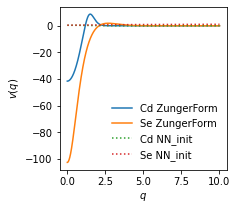

Epoch [500/1000], Validation Loss: 1262.0920


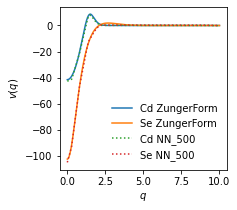

Epoch [1000/1000], Validation Loss: 1254.3737


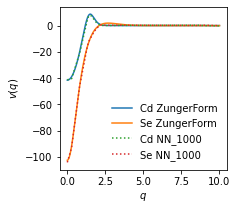

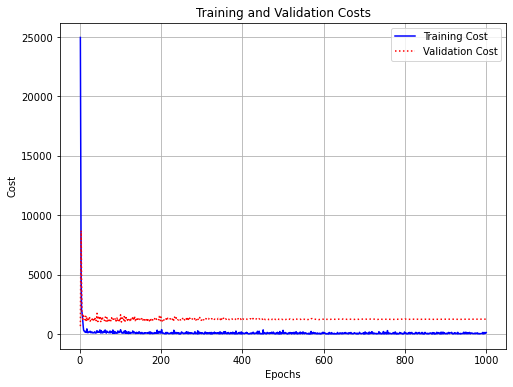

GPU training: elapsed time: 56.52028489112854 seconds


In [15]:
# Create Net model class
PPmodel = nn_models.Net_relu_xavier_BN_dropout_decay([1, 20, 20, 20, 2])

# Validating on the initialized NN model
# print("list(model.parameters()):\n ", list(PPmodel.parameters()))
# print("\nmodel.state_dict():\n ", PPmodel.state_dict())
PPmodel.eval()
# print(PPmodel(torch.tensor([[1.0]])))
# print(PPmodel(torch.tensor([[1.0], [2.0]])))
NN_init = PPmodel(val_dataset.q)
plotPP([val_dataset.q, val_dataset.q], [val_dataset.vq_Cd, NN_init[:, 0]], [val_dataset.vq_Se, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"])

# Initialize the NN parameters to fit the current Zunger form
def init_Zunger_weighted_mse(yhat,y,weight):
    return torch.mean(weight*(yhat-y)**2)
#criterion=nn.MSELoss()

def init_Zunger_train(model, train_loader, val_loader, criterion, optimizer, scheduler, scheduler_step, epochs, plot_every):
    training_cost=[]
    validation_cost=[]
    for epoch in range(epochs):
        train_cost = 0
        val_cost = 0
        for q, vq_Cd, vq_Se, w in train_loader:
            model.train()
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            train_cost += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_cost.append(train_cost)
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
        for q, vq_Cd, vq_Se, w in val_loader:
            model.eval()
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            val_cost += loss.item()
            if (epoch + 1) % plot_every == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {loss.item():.4f}')
                plotPP([q, q], [vq_Cd, Cd_pred], [vq_Se, Se_pred], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"]);

        validation_cost.append(val_cost)
    plot_training_validation_cost(training_cost, validation_cost)
    return 

def init_Zunger_train_GPU(model, device, train_loader, val_loader, criterion, optimizer, scheduler, scheduler_step, epochs, plot_every):
    training_cost=[]
    validation_cost=[]
    model.to(device)
    for epoch in range(epochs):
        train_cost = 0
        val_cost = 0
        for q, vq_Cd, vq_Se, w in train_loader:
            model.train()
            q = q.to(device) 
            vq_Cd = vq_Cd.to(device)
            vq_Se = vq_Se.to(device)
            w = w.to(device)
            
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            train_cost += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        training_cost.append(train_cost)
        if epoch > 0 and epoch % scheduler_step == 0:
            scheduler.step()
        for q, vq_Cd, vq_Se, w in val_loader:
            model.eval()
            q = q.to(device) 
            vq_Cd = vq_Cd.to(device)
            vq_Se = vq_Se.to(device)
            w = w.to(device)
            
            outputs = model(q)
            Cd_pred, Se_pred = torch.split(outputs, 1, dim=1)
            loss = criterion(Cd_pred, vq_Cd, w) + criterion(Se_pred, vq_Se, w)
            val_cost += loss.item()
            if (epoch + 1) % plot_every == 0:
                plot_q = q.cpu()
                plot_vq_Cd = vq_Cd.cpu()
                plot_Cd_pred = Cd_pred.cpu()
                plot_vq_Se = vq_Se.cpu()
                plot_Se_pred = Se_pred.cpu()
                print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {loss.item():.4f}')
                plotPP([plot_q, plot_q], [plot_vq_Cd, plot_Cd_pred], [plot_vq_Se, plot_Se_pred], ["ZungerForm", f"NN_{epoch+1}"], ["-", ":"]);

        validation_cost.append(val_cost)
    plot_training_validation_cost(training_cost, validation_cost)
    return 

init_Zunger_criterion = init_Zunger_weighted_mse
init_Zunger_optimizer = torch.optim.Adam(PPmodel.parameters(), lr=0.1)
init_Zunger_scheduler = ExponentialLR(init_Zunger_optimizer, gamma=0.90)
trainloader = DataLoader(dataset = train_dataset, batch_size = int(train_dataset.len/4),shuffle=True)
validationloader = DataLoader(dataset = val_dataset, batch_size =val_dataset.len, shuffle=False)

init_Zunger_num_epochs = 1000
plotEvery = 500
'''
start_time = time.time()
init_Zunger_train(PPmodel, trainloader, validationloader, init_Zunger_criterion, init_Zunger_optimizer, init_Zunger_scheduler, 20, init_Zunger_num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"CPU training: elapsed time: {elapsed_time} seconds")
'''
start_time = time.time()
init_Zunger_train_GPU(PPmodel, device, trainloader, validationloader, init_Zunger_criterion, init_Zunger_optimizer, init_Zunger_scheduler, 20, init_Zunger_num_epochs, plotEvery)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"GPU training: elapsed time: {elapsed_time} seconds")

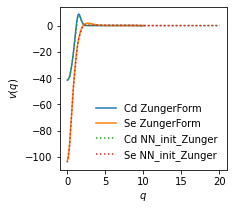

In [18]:
PPmodel.eval()
PPmodel.cpu()
plotqGrid = torch.linspace(0.0, 20.0, 3*NQGRID).view(-1, 1)
NN = PPmodel(plotqGrid.view(-1, 1))
plotPP([val_dataset.q, plotqGrid], [val_dataset.vq_Cd, NN[:, 0]], [val_dataset.vq_Se, NN[:, 1]], ["ZungerForm", f"NN_init_Zunger"], ["-", ":"]);

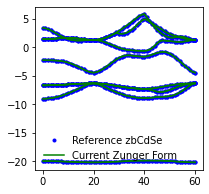

Using this code, can I reproduce the reference band structure to within 1e-11 eV? 
True


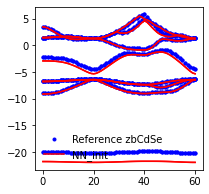

In [19]:
basisStates = basis(maxKE, scale, unitCellVectors, gVectors, cellVolume)

current_Zunger_BandStruct = calcBandStruct(False, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, current_Zunger_BandStruct], ["bo", "g-"], ["Reference zbCdSe", "Current Zunger Form"])
print("Using this code, can I reproduce the reference band structure to within 1e-11 eV? ")
print(torch.allclose(Eref_zbCdSe, current_Zunger_BandStruct, atol=1e-11))

NN_init_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
plotBandStruct([Eref_zbCdSe, NN_init_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_init"])

Loss: 11674.10673034816
Parameter: hidden_l.0.weight, Gradient Norm: 0.03926268643324203
Parameter: hidden_l.0.bias, Gradient Norm: 2.241388238501002e-11
Parameter: hidden_l.1.weight, Gradient Norm: 834.9245702370974
Parameter: hidden_l.1.bias, Gradient Norm: 3.715302911376117e-12
Parameter: hidden_l.2.weight, Gradient Norm: 751.78209051421
Parameter: hidden_l.2.bias, Gradient Norm: 9.709307365594373e-12
Parameter: hidden_l.3.weight, Gradient Norm: 9635.05101676826
Parameter: hidden_l.3.bias, Gradient Norm: 787.1143055069472
Parameter: hidden_bn.0.weight, Gradient Norm: 1686.8686619210373
Parameter: hidden_bn.0.bias, Gradient Norm: 1880.8510265318869
Parameter: hidden_bn.1.weight, Gradient Norm: 1104.7088960053047
Parameter: hidden_bn.1.bias, Gradient Norm: 1269.2337210925953
Parameter: hidden_bn.2.weight, Gradient Norm: 6385.179505442797
Parameter: hidden_bn.2.bias, Gradient Norm: 2483.8757442765063
Loss: 4175.8003001791185
Parameter: hidden_l.0.weight, Gradient Norm: 0.11858419955718

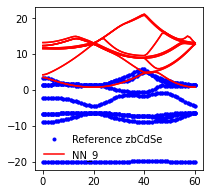

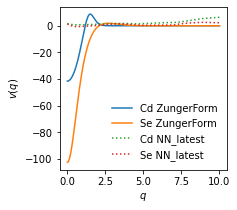

Loss: 256.500465840989
Parameter: hidden_l.0.weight, Gradient Norm: 0.0011607483555895793
Parameter: hidden_l.0.bias, Gradient Norm: 6.145905900306837e-13
Parameter: hidden_l.1.weight, Gradient Norm: 12.365785059237945
Parameter: hidden_l.1.bias, Gradient Norm: 5.215429170255536e-14
Parameter: hidden_l.2.weight, Gradient Norm: 13.719431664402293
Parameter: hidden_l.2.bias, Gradient Norm: 4.48775276014822e-15
Parameter: hidden_l.3.weight, Gradient Norm: 13.120897018984653
Parameter: hidden_l.3.bias, Gradient Norm: 1.1711447975856215
Parameter: hidden_bn.0.weight, Gradient Norm: 23.211362098583358
Parameter: hidden_bn.0.bias, Gradient Norm: 8.128012384055538
Parameter: hidden_bn.1.weight, Gradient Norm: 9.595858718570366
Parameter: hidden_bn.1.bias, Gradient Norm: 4.278039468131624
Parameter: hidden_bn.2.weight, Gradient Norm: 11.857200999502531
Parameter: hidden_bn.2.bias, Gradient Norm: 5.1778631702918485


In [15]:
learning_rate = 0.1
optimizer = torch.optim.Adam(PPmodel.parameters(), lr = learning_rate)
# Add learning rate scheduling 


# torch.autograd.set_detect_anomaly(False)

def train_model(epochs):
    for epoch in range(epochs):
        # for name, param in PPmodel.named_parameters():
        #     print(f"Parameter: {name}, Size: {param.size()}")
        #     print(param.data)
        NN_BandStruct = calcBandStruct(True, basisStates, nkpt, kpt_zbCdSe, nAtoms, cellVolume, nBands)
        
        if (epoch + 1) % 10 == 0:
            plotBandStruct([Eref_zbCdSe, NN_BandStruct], ["bo", "r-"], ["Reference zbCdSe", "NN_"+str(epoch)])
            NN_latest = PPmodel(qGrid.view(-1, 1))
            plotPP([qGrid, qGrid], [CdPP, NN_latest[:, 0]], [SePP, NN_latest[:, 1]], ["ZungerForm", "NN_latest"], ["-", ":"])
        
        loss = ((Eref_zbCdSe - NN_BandStruct) ** 2).mean()
        print(f"Loss: {loss}")
        optimizer.zero_grad()
        loss.backward()
        for name, param in PPmodel.named_parameters():
            if param.grad is not None:
                print(f"Parameter: {name}, Gradient Norm: {param.grad.norm().item()}")
        optimizer.step()

train_model(10)

Loss: 0.23125051695155263
Parameter: input_layer.weight, Gradient Norm: 8.941249152061554e-07
Parameter: input_layer.bias, Gradient Norm: 4.4013281846279857e-16
Parameter: bn1.weight, Gradient Norm: 0.12879878125843594
Parameter: bn1.bias, Gradient Norm: 0.11986400561621056
Parameter: hidden_layer1.weight, Gradient Norm: 0.07952926101113267
Parameter: hidden_layer1.bias, Gradient Norm: 8.057373149244846e-17
Parameter: bn2.weight, Gradient Norm: 0.09711462815092041
Parameter: bn2.bias, Gradient Norm: 0.04483546801687504
Parameter: hidden_layer2.weight, Gradient Norm: 0.04937750877823435
Parameter: hidden_layer2.bias, Gradient Norm: 1.3597696624546456e-16
Parameter: bn3.weight, Gradient Norm: 0.14830534631857695
Parameter: bn3.bias, Gradient Norm: 0.06948192712118179
Parameter: output_layer.weight, Gradient Norm: 0.18998881401995246
Parameter: output_layer.bias, Gradient Norm: 0.00484948506277803
Loss: 0.230342343940474
Parameter: input_layer.weight, Gradient Norm: 8.86443177458509e-07
P

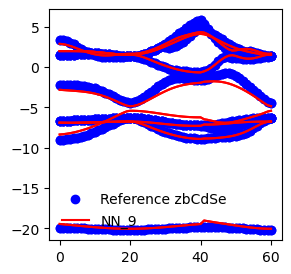

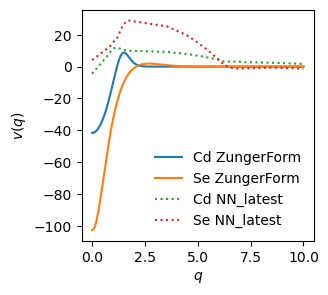

Loss: 0.22353046521076642
Parameter: input_layer.weight, Gradient Norm: 5.984716988748698e-07
Parameter: input_layer.bias, Gradient Norm: 6.358397016718946e-16
Parameter: bn1.weight, Gradient Norm: 0.08912450854315612
Parameter: bn1.bias, Gradient Norm: 0.11411941885749695
Parameter: hidden_layer1.weight, Gradient Norm: 0.05381960496921681
Parameter: hidden_layer1.bias, Gradient Norm: 8.934463377305758e-16
Parameter: bn2.weight, Gradient Norm: 0.10449768768217299
Parameter: bn2.bias, Gradient Norm: 0.0365433963193246
Parameter: hidden_layer2.weight, Gradient Norm: 0.0545198780278277
Parameter: hidden_layer2.bias, Gradient Norm: 1.4399379549166558e-16
Parameter: bn3.weight, Gradient Norm: 0.1710621812575603
Parameter: bn3.bias, Gradient Norm: 0.07524923650553533
Parameter: output_layer.weight, Gradient Norm: 0.2270688470851019
Parameter: output_layer.bias, Gradient Norm: 0.004740520388177016
Loss: 0.2227716453105103
Parameter: input_layer.weight, Gradient Norm: 6.006845765891607e-07
Par

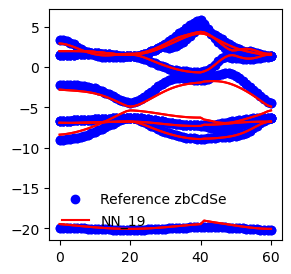

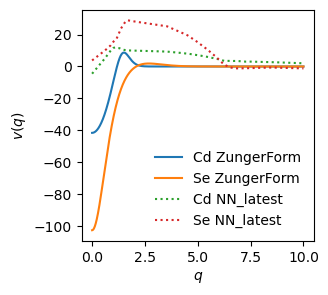

Loss: 0.21629589311105632
Parameter: input_layer.weight, Gradient Norm: 5.575910824293177e-07
Parameter: input_layer.bias, Gradient Norm: 3.536928810696967e-16
Parameter: bn1.weight, Gradient Norm: 0.09476491286472465
Parameter: bn1.bias, Gradient Norm: 0.1142961001209053
Parameter: hidden_layer1.weight, Gradient Norm: 0.05133033137389393
Parameter: hidden_layer1.bias, Gradient Norm: 1.3049119252003959e-15
Parameter: bn2.weight, Gradient Norm: 0.08783413634032847
Parameter: bn2.bias, Gradient Norm: 0.0418592125682181
Parameter: hidden_layer2.weight, Gradient Norm: 0.044767006985453224
Parameter: hidden_layer2.bias, Gradient Norm: 1.1222898256113188e-16
Parameter: bn3.weight, Gradient Norm: 0.1279978570490766
Parameter: bn3.bias, Gradient Norm: 0.06471452498456592
Parameter: output_layer.weight, Gradient Norm: 0.16628154030001474
Parameter: output_layer.bias, Gradient Norm: 0.004422390561570375
Loss: 0.21560781452397607
Parameter: input_layer.weight, Gradient Norm: 5.469656380749168e-07

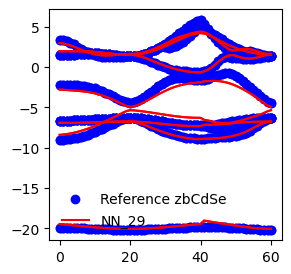

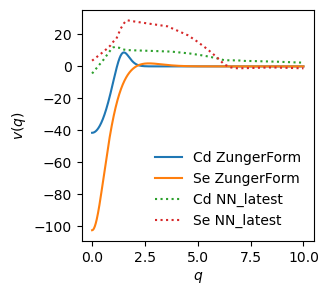

Loss: 0.20948994784683397
Parameter: input_layer.weight, Gradient Norm: 5.44059315130554e-07
Parameter: input_layer.bias, Gradient Norm: 6.871142012442468e-16
Parameter: bn1.weight, Gradient Norm: 0.0890142002724754
Parameter: bn1.bias, Gradient Norm: 0.11265221830724453
Parameter: hidden_layer1.weight, Gradient Norm: 0.04757357053937145
Parameter: hidden_layer1.bias, Gradient Norm: 1.4702769679665146e-15
Parameter: bn2.weight, Gradient Norm: 0.08783817606082366
Parameter: bn2.bias, Gradient Norm: 0.039820618117872686
Parameter: hidden_layer2.weight, Gradient Norm: 0.043506456982164536
Parameter: hidden_layer2.bias, Gradient Norm: 6.274265627385488e-17
Parameter: bn3.weight, Gradient Norm: 0.132577585519428
Parameter: bn3.bias, Gradient Norm: 0.067415139244947
Parameter: output_layer.weight, Gradient Norm: 0.17695555004417848
Parameter: output_layer.bias, Gradient Norm: 0.004456815425070088
Loss: 0.2088160945532663
Parameter: input_layer.weight, Gradient Norm: 5.412359840853343e-07
Par

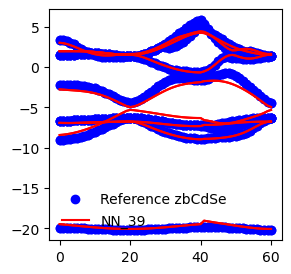

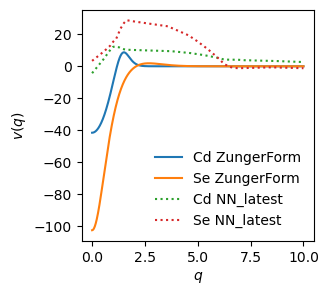

Loss: 0.20291024074446168
Parameter: input_layer.weight, Gradient Norm: 5.364275038323978e-07
Parameter: input_layer.bias, Gradient Norm: 3.3302258680300995e-16
Parameter: bn1.weight, Gradient Norm: 0.09413547766851688
Parameter: bn1.bias, Gradient Norm: 0.11197392031402828
Parameter: hidden_layer1.weight, Gradient Norm: 0.04904352624494306
Parameter: hidden_layer1.bias, Gradient Norm: 6.484754873558698e-16
Parameter: bn2.weight, Gradient Norm: 0.07624905765491463
Parameter: bn2.bias, Gradient Norm: 0.04243450779690731
Parameter: hidden_layer2.weight, Gradient Norm: 0.04251364343141461
Parameter: hidden_layer2.bias, Gradient Norm: 1.4055133858957566e-16
Parameter: bn3.weight, Gradient Norm: 0.10766827288320885
Parameter: bn3.bias, Gradient Norm: 0.0613366413412335
Parameter: output_layer.weight, Gradient Norm: 0.14291290500944456
Parameter: output_layer.bias, Gradient Norm: 0.004135847648360436
Loss: 0.20227157616844954
Parameter: input_layer.weight, Gradient Norm: 5.378331359192419e-0

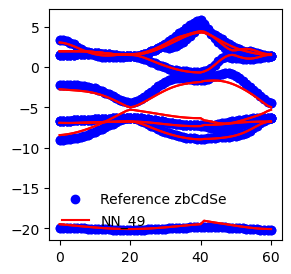

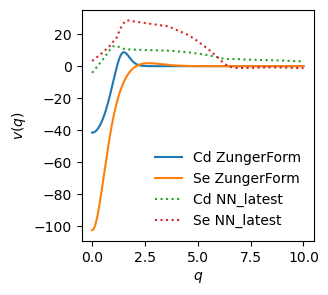

Loss: 0.1966914463576074
Parameter: input_layer.weight, Gradient Norm: 4.877051127443317e-07
Parameter: input_layer.bias, Gradient Norm: 3.7637111756881927e-16
Parameter: bn1.weight, Gradient Norm: 0.0851695297669975
Parameter: bn1.bias, Gradient Norm: 0.10617397906909884
Parameter: hidden_layer1.weight, Gradient Norm: 0.04178459508244649
Parameter: hidden_layer1.bias, Gradient Norm: 1.8537169878495224e-16
Parameter: bn2.weight, Gradient Norm: 0.07280971318210804
Parameter: bn2.bias, Gradient Norm: 0.03869811147636091
Parameter: hidden_layer2.weight, Gradient Norm: 0.03987939769864165
Parameter: hidden_layer2.bias, Gradient Norm: 1.2633703345317404e-16
Parameter: bn3.weight, Gradient Norm: 0.10504606769862644
Parameter: bn3.bias, Gradient Norm: 0.05994484142916752
Parameter: output_layer.weight, Gradient Norm: 0.14262848546590223
Parameter: output_layer.bias, Gradient Norm: 0.003919116029429566


In [19]:
train_model(50)

In [20]:
torch.save(PPmodel.state_dict(), 'PPmodel_1_20_20_2_run310.pth')

loaded_model = Net()
loaded_model.load_state_dict(torch.load('PPmodel_1_20_20_2_run310.pth'))

<All keys matched successfully>

tensor([[ 0.8000, -1.7540],
        [ 0.7114,  0.9516]], grad_fn=<AddmmBackward0>)


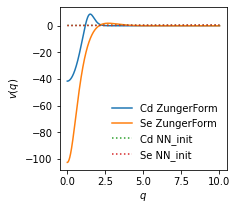

In [6]:
# Create Net model class
import nn_models

# Added batch normalization, xavier initialization
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(1, 20) 
        self.bn1 = nn.BatchNorm1d(20) 

        self.hidden_layer1 = nn.Linear(20, 20) 
        self.bn2 = nn.BatchNorm1d(20)  

        self.hidden_layer2 = nn.Linear(20, 20) 
        self.bn3 = nn.BatchNorm1d(20) 

        self.output_layer = nn.Linear(20, 2) 

        # Xavier initialization for weights
        init.xavier_normal_(self.input_layer.weight)
        init.xavier_normal_(self.hidden_layer1.weight)
        init.xavier_normal_(self.hidden_layer2.weight)
        init.xavier_normal_(self.output_layer.weight)

    def forward(self, x):
        x = torch.relu(self.bn1(self.input_layer(x)))  
        x = torch.relu(self.bn2(self.hidden_layer1(x)))
        x = torch.relu(self.bn3(self.hidden_layer2(x)))
        x = self.output_layer(x)
        return x

PPmodel = Net()


# print("list(model.parameters()):\n ", list(PPmodel.parameters()))
# print("\nmodel.state_dict():\n ", PPmodel.state_dict())
print(PPmodel(torch.tensor([[1.0], [2.0]])))
# print(PPmodel(torch.tensor([[1.0]])))

# Validating on the initialized NN model
PPmodel.eval()
NN_init = PPmodel(qGrid.view(-1, 1))
plotPP([qGrid, qGrid], [CdPP, NN_init[:, 0]], [SePP, NN_init[:, 1]], ["ZungerForm", "NN_init"], ["-", ":"])